In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import seaborn as sns
import cv2
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!cd

C:\Users\srina\mammal_classification


Let's build a model that classifie 9 types of mammals. The challenge that we will certainly face is the lack of data.

In this note book we will try to use the predefined model **EfficientNetB0**, also we will  to use data augmentation and transfer learning to see if there will be any imporvement on accuracy.

## Data preprocessing

In [3]:
# loading data into a dataframe
Path = r"C:\Users\srina\mammal_classification\mammals"
db = {"path": [] , "label": []}

mammals = os.listdir(Path)
for mammal in mammals:
        images = os.listdir(os.path.join(Path,mammal))
        db["path"].extend([*map(lambda x : Path + f"/{mammal}/" + x, images)])
        db["label"].extend([mammal]*len(images)) 

db = pd.DataFrame(db)

showing some exemples of our data

In [4]:
print(db.shape)
db.sample(5)

(826, 2)


,path,label
813,C:\Users\srina\mammal_classification\mammals/w...,wolf
97,C:\Users\srina\mammal_classification\mammals/c...,cat
59,C:\Users\srina\mammal_classification\mammals/b...,bear
319,C:\Users\srina\mammal_classification\mammals/e...,elephant
639,C:\Users\srina\mammal_classification\mammals/t...,tiger


removing bad files

In [5]:
import PIL
from PIL import UnidentifiedImageError

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

for img_p in db.path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            db = db.drop(db[db['path'] == img_p].index)
            print(img_p)

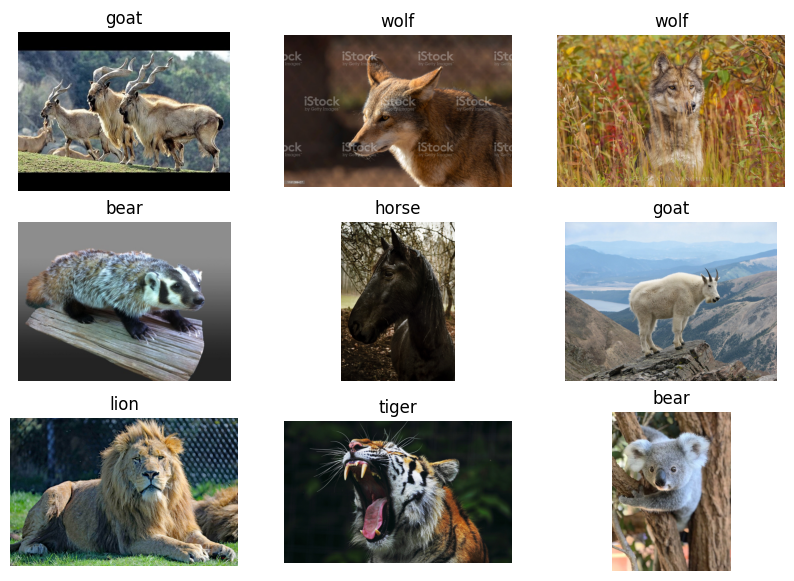

In [6]:
fig, axes = plt.subplots(3, 3 ,figsize=(10, 7))

samples = db.sample(9)

for i in range(3):
    for j in range(3):
        im = cv2.cvtColor(cv2.imread(samples.iloc[3*i+j, 0]), cv2.COLOR_BGR2RGB)
        axes[i,j].imshow(im)
        axes[i,j].set_title(samples.iloc[3*i+j, 1])
        axes[i,j].axis("off")
plt.show()


#### the number of images in each class

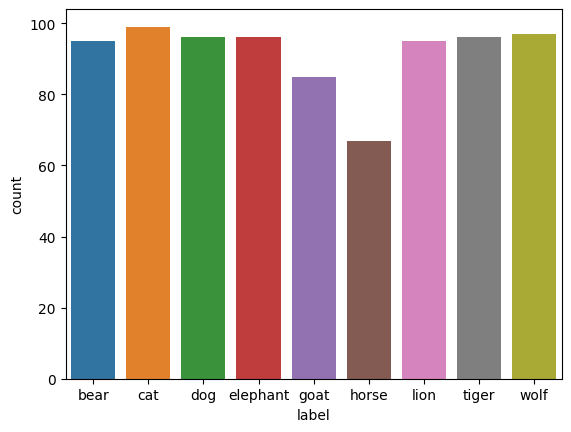

In [7]:
sns.countplot(data = db, x="label")
plt.show()

## Model 1 

let's try to build a model, training it using the available data and see the results.
the model used here is **EfficientNetB0**

In [8]:
model = tf.keras.applications.EfficientNetB0(weights=None,input_shape=(224,224,3),classes=9)


In [9]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=0.01),
              metrics = ["accuracy"])

let's split our data and fit the model

In [10]:
X_train , X_test = train_test_split(db,test_size=.2,random_state=42)

#### the number of images of each class in test data

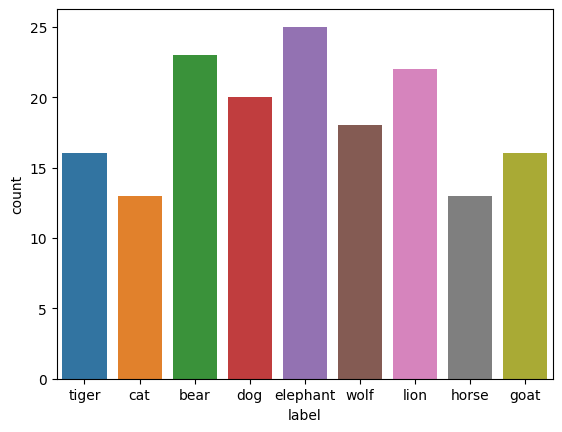

In [11]:
sns.countplot(x=X_test["label"])
plt.show()

Preparing data for the model

In [12]:
img_gen1 = tf.keras.preprocessing.image.ImageDataGenerator()

x_train = img_gen1.flow_from_dataframe(dataframe=X_train, x_col="path", y_col="label",
                                      target_size=(224,224))
x_test = img_gen1.flow_from_dataframe(dataframe=X_test, x_col="path", y_col="label",
                                      target_size=(224,224))

Found 660 validated image filenames belonging to 9 classes.
Found 165 validated image filenames belonging to 9 classes.


c:\users\srina\appdata\local\programs\python\python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [13]:

model.fit(x_train,validation_data=x_test, shuffle=True,epochs=10)

Epoch 1/10
21/21 [==============================] - 203s 7s/step - loss: 4.2192 - accuracy: 0.1409 - val_loss: 2.2642 - val_accuracy: 0.0970
Epoch 2/10
21/21 [==============================] - 68s 3s/step - loss: 3.2904 - accuracy: 0.1500 - val_loss: 2.2525 - val_accuracy: 0.0970
Epoch 3/10
21/21 [==============================] - 54s 3s/step - loss: 2.6069 - accuracy: 0.2076 - val_loss: 2.2748 - val_accuracy: 0.0970
Epoch 4/10
21/21 [==============================] - 54s 3s/step - loss: 2.6117 - accuracy: 0.1909 - val_loss: 2.3055 - val_accuracy: 0.1273
Epoch 5/10
21/21 [==============================] - 54s 3s/step - loss: 2.4865 - accuracy: 0.2364 - val_loss: 2.2953 - val_accuracy: 0.1273
Epoch 6/10
21/21 [==============================] - 55s 3s/step - loss: 2.4839 - accuracy: 0.2258 - val_loss: 2.3819 - val_accuracy: 0.1273
Epoch 7/10
21/21 [==============================] - 54s 3s/step - loss: 2.3347 - accuracy: 0.2424 - val_loss: 2.5053 - val_accuracy: 0.0970
Epoch 8/10
21/21 [=

In [14]:
model.evaluate(x_test)

6/6 [==============================] - 5s 766ms/step - loss: 2.7822 - accuracy: 0.1273


[2.7822062969207764, 0.12727272510528564]

The first model overfits. Solving this problem requires more data so we will use data augmentation and transfer learning. let try this in model 2

## Model 2

### Data Augmentation

The technics of data augmentation that we will use are :
1. Random Rotation
2. Random Zoom

In [15]:
img_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(
         zoom_range = .5,
         rotation_range = .4)

x_train = img_gen2.flow_from_dataframe(dataframe=X_train, x_col="path", y_col="label",
                                      target_size=(224,224))
x_test = img_gen2.flow_from_dataframe(dataframe=X_test, x_col="path", y_col="label",
                                      target_size=(224,224))

Found 660 validated image filenames belonging to 9 classes.
Found 165 validated image filenames belonging to 9 classes.


c:\users\srina\appdata\local\programs\python\python38\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


### Transfer learning

In [16]:
effnet = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                              include_top=False,input_shape=(224,224,3))

16705208/16705208 [==============================] - 6s 0us/step


In [17]:
input = tf.keras.layers.Input((224,224,3))
x = effnet(input)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.models.Model(inputs = input , outputs = output)

In [18]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=0.001),
              metrics = ["accuracy"])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529 

### Callbacks

In [20]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="./mammals.h5",
    verbose=1,
    save_best_only=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", mode="min", verbose=1, patience=3, min_delta=0.0001, factor=0.2
)

In [21]:
model.fit(x_train, validation_data = x_test, shuffle=True,epochs=20, callbacks=[earlystopping, reduce_lr])

Epoch 1/20
21/21 [==============================] - 73s 3s/step - loss: 1.0762 - accuracy: 0.6909 - val_loss: 0.9877 - val_accuracy: 0.7636 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - 58s 3s/step - loss: 0.4687 - accuracy: 0.8561 - val_loss: 1.1816 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - 58s 3s/step - loss: 0.2879 - accuracy: 0.9061 - val_loss: 1.4950 - val_accuracy: 0.6788 - lr: 0.0010
Epoch 4/20
21/21 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9424
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21/21 [==============================] - 58s 3s/step - loss: 0.1937 - accuracy: 0.9424 - val_loss: 1.5595 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 5/20
21/21 [==============================] - 60s 3s/step - loss: 0.1105 - accuracy: 0.9682 - val_loss: 0.9236 - val_accuracy: 0.7636 - lr: 2.0000e-04
Epoch 6/20
21/21 [==============================] - 60s 3s/step - loss:

In [22]:
model.evaluate(x_test)

6/6 [==============================] - 6s 827ms/step - loss: 0.6699 - accuracy: 0.8545


[0.6699098944664001, 0.8545454740524292]

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529 

## Testing the model on some images from internet

In [23]:
def predict_class(image):
    classes = list(x_train.class_indices.keys())
    img = cv2.imread(image)
    img = cv2.resize(img, (224,224))
    prediction = model.predict(img.reshape(1,224,224,3) , verbose = 0)
    pred_class , prob = classes[np.argmax(prediction)] , np.max(prediction) * 100
    
    # show the image and the prediction
    plt.imshow(cv2.cvtColor(img , cv2.COLOR_BGR2RGB))
    plt.title(pred_class + " " + str(prob) + "%")
    plt.axis("off")
    plt.show()

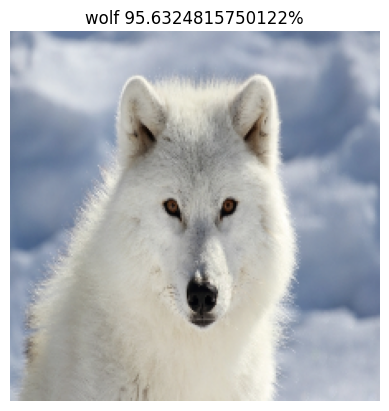

In [38]:
import requests

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

# Example URL of the image you want to download
image_url = "https://safeworldwide.org/wp-content/uploads/2022/03/Screen-Shot-2022-03-23-at-1.13.29-PM.png"

# Define the filename for the downloaded image
filename = "Screen-Shot-2022-03-23-at-1.13.29-PM.png"

# Download the image from the website
download_image(image_url, filename)

# Now you can pass the downloaded image path to your predict_class function
predict_class(filename)


In [39]:
# Assuming `model` is your trained TensorFlow model
model.save("model.h5")  # Save the entire model including architecture and weights


c:\users\srina\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Assuming `model` is your trained TensorFlow model
model.save("model.keras")  # Save the model in native Keras format
